In [1]:
# -*- coding: utf-8 -*-
"""
To look for correlation between transcription and 3C contacts. 
"""
from pylab import *
from itertools import islice
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# smooth function:
def smoothListGaussian(list,strippedXs=False,degree=5):  
    window=degree*2-1  
    weight=np.array([1.0]*window)  
    weightGauss=[]  
    for i in range(window):  
        i=i-degree+1  
        frac=i/float(window)  
        gauss=1/(np.exp((4*(frac))**2))  
        weightGauss.append(gauss)  
    weight=np.array(weightGauss)*weight  
    smoothed=[0.0]*(len(list)-window)  
    for i in range(len(smoothed)):  
        smoothed[i]=sum(np.array(list[i:i+window])*weight)/sum(weight)  
    return smoothed

In [2]:
matscn1 = np.loadtxt('../data/MAT_scn_wt.txt')
matscn1 = matscn1[0:613,0:613]
# plots:
b=np.diagonal(matscn1)
print(b.shape)

# transcription data:
chip = np.loadtxt("../data/wt_bin_fpkm.txt", usecols=(0,1), skiprows=1)
c=log(chip[:,1])
print(c.shape)

# with smoothing the signals:
pearsonr(smoothListGaussian( (b-mean(b))/std(b) ), smoothListGaussian( (c-mean(c))/std(c) ))

(613,)
(613,)


(0.5079533723288849, 6.204971108573681e-41)

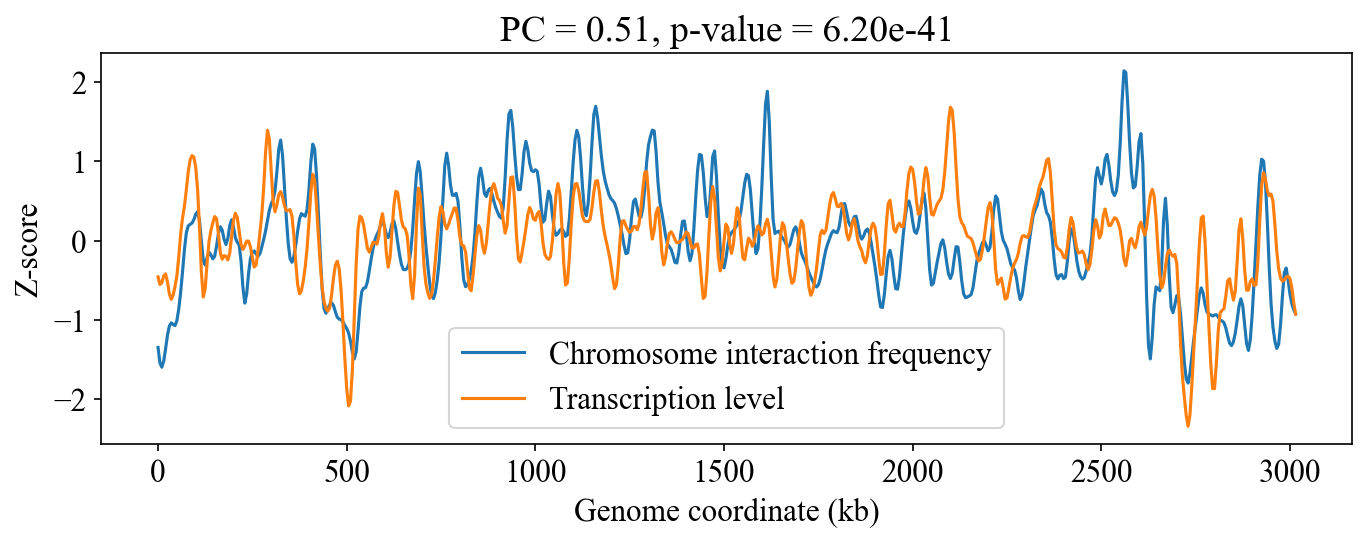

In [4]:
fig, ax = plt.subplots(figsize=(9, 3.5), dpi=150, constrained_layout=True)
plt.rc('font',family='Times New Roman') 
matplotlib.rcParams.update({'font.size': 15})

y1s = smoothListGaussian( (b-mean(b))/std(b) )
y2s = smoothListGaussian( (c-mean(c))/std(c) )
x=np.arange(0,len(y1s))

ax.plot(x, y1s, label='Chromosome interaction frequency')
ax.plot(x, y2s, label='Transcription level')

ax.set_xlabel("Genome coordinate (kb)")
ax.set_ylabel("Z-score")
plt.title('PC = 0.51, p-value = 6.20e-41')
tick_locs = range(0,x.shape[0],100)
tick_lbls = (array(range(0,x.shape[0],100)) * 5).tolist()
plt.xticks(tick_locs, tick_lbls)
legend()

plt.savefig("../pictures/wt_correlation_transcription_3C.jpg", bbox_inches='tight')

# dist_laws_transcription_3C

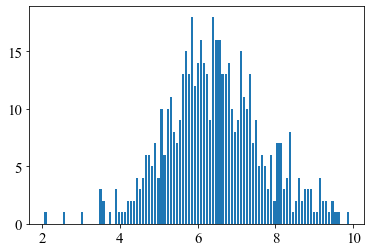

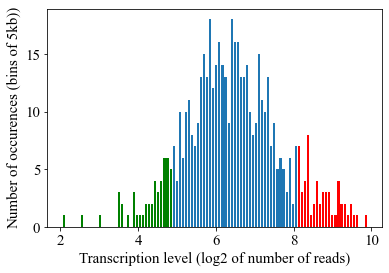

In [5]:
# transcription data:
chip = chip[:530,]

per10 = np.percentile(log(chip[:,1]),10)
per90 = np.percentile(log(chip[:,1]),90)

hist, bins = np.histogram(log(chip[:,1]), 100)

def my_histo(V,number_of_bins):    
    hist, bins = np.histogram(V, bins = number_of_bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()
    return center,hist,width

c,h,w=my_histo(log(chip[:,1]), 100)

plt.bar(c, h, align='center', width=w)
plt.bar(c[c<per10], h[c<per10], align='center', width=w,color="green")
plt.bar(c[c>per90], h[c>per90], align='center', width=w,color="red")

plt.xlabel("Transcription level (log2 of number of reads)");
plt.ylabel("Number of occurences (bins of 5kb))");
plt.show()

In [6]:
matscn1 = matscn1[:530,:530]

# with rna-seq
# very expressed:
indices_highly = np.where(log(chip[:,1]) > per90)
mat_highly = matscn1[indices_highly[0],:]
print(mat_highly.shape)

(53, 530)


In [7]:
def dist_law(A,indices):   
    n1 = A.shape[0]
    n2 = A.shape[1]
    print("Number of positions of the matrix entetered:")
    print(n1)
    print("Number of scales of the matrix entetered:")
    print(n2)
    
    dist = np.zeros((n2//2 +1, 1))
    n_int = np.zeros((n1, 1))

    for nw in range(0,n2//2 +1):   # scales
        somme = []
        for j in range(0,n1):
                i = indices[j]
                kp= i - nw
                lp= i + nw
                if kp < 0 :
                    kp = n2 +kp
                if lp < 0 :
                    lp = n2 +lp
                if kp >= n2 :
                    kp = kp - n2
                if lp >= n2:
                    lp = lp - n2
                    
                somme.append(A[j,kp])
                somme.append(A[j,lp])
                
        dist[nw] = np.mean(somme)                     
    return dist

dih=dist_law(mat_highly,indices_highly[0])
print(dih.shape)

Number of positions of the matrix entetered:
53
Number of scales of the matrix entetered:
530
(266, 1)


In [8]:
# poorly expressed:
indices_poor=np.where(log(chip[:,1]) < per10)
#indices_poor=indices_poor[0];
mat_poor= matscn1[indices_poor[0],:]
print(mat_poor.shape)
dip=dist_law(mat_poor,indices_poor[0])

# normaly expressed:
#indices_norm=np.where( (log(chip) > 6) and (log(chip) < 9) );
indices_norm = np.where( logical_and( (log(chip[:,1]) > per10) , (log(chip[:,1]) < per90) ) )
mat_norm= matscn1[indices_norm[0],:]
print(mat_norm.shape)
din=dist_law(mat_norm,indices_norm[0])

(53, 530)
Number of positions of the matrix entetered:
53
Number of scales of the matrix entetered:
530
(424, 530)
Number of positions of the matrix entetered:
424
Number of scales of the matrix entetered:
530


In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.pyplot as plt

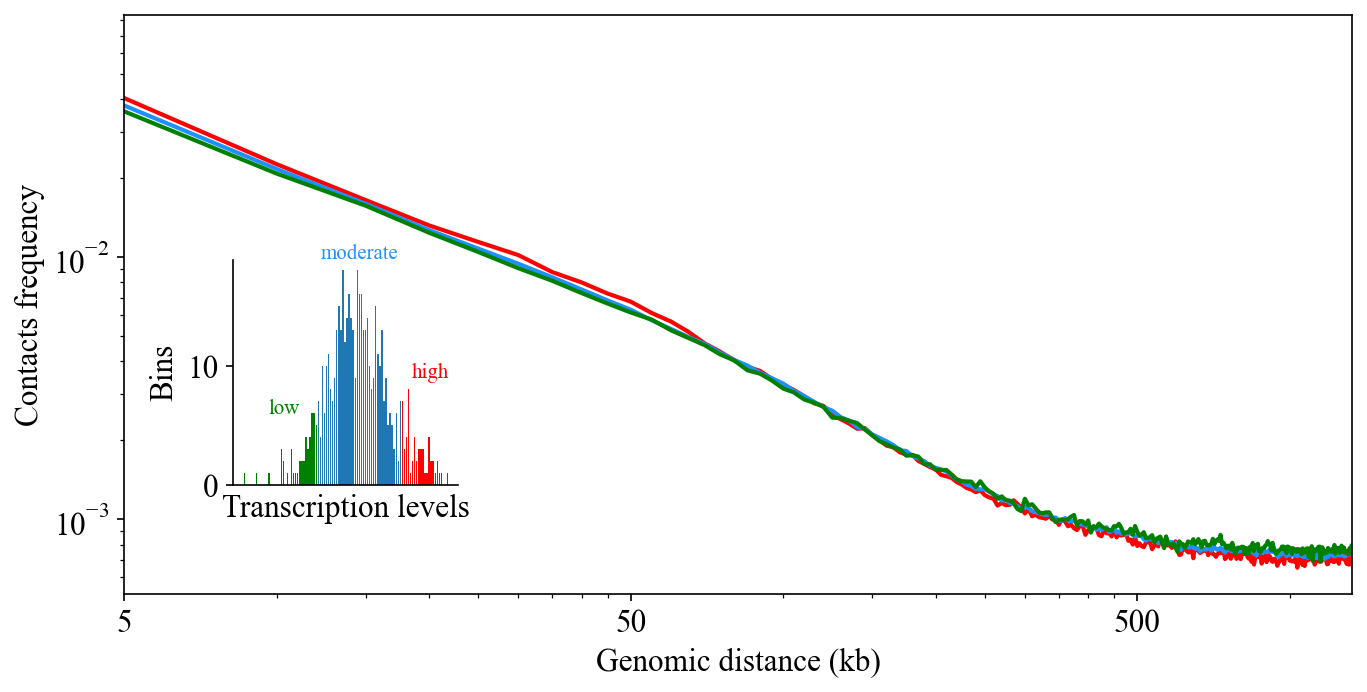

In [10]:
fig, ax = plt.subplots(figsize=(9, 4.5), dpi=150, constrained_layout=True)
plt.rc('font',family='Times New Roman')
matplotlib.rcParams.update({'font.size': 15})
ax.plot(dih,color="red",label="very transcribed",linewidth=2.0)
ax.plot(din,color="dodgerblue",label="moderately transcribed",linewidth=2.0)
ax.plot(dip,color="green",label="poorly transcribed",linewidth=2.0)

ax.set_xlim(1,266)
ax.set_xscale('log')
ax.set_yscale('log')

ticks = ax.set_xticks([1,10,100])
labels = ax.set_xticklabels([5,50,500])

ax.set_xlabel("Genomic distance (kb)")
ax.set_ylabel("Contacts frequency")

axins = inset_axes(ax, width=1.5, height=1.5, loc='lower left', borderpad=3.5)
axins.bar(c, h, align='center', width=w)
axins.bar(c[c<per10], h[c<per10], align='center', width=w,color="green")
axins.bar(c[c>per90], h[c>per90], align='center', width=w,color="red")
axins.set_xticks([])
axins.text(3, 6, 'low', fontsize = 10, color ="green")
axins.text(5, 19, 'moderate', fontsize = 10, color ="dodgerblue")
axins.text(8.5, 9, 'high', fontsize = 10, color ="red")

for key, spine in axins.spines.items():
    # 'left', 'right', 'bottom', 'top'
    if key == 'top' or key == 'right':
        spine.set_visible(False)
axins.set_xlabel("Transcription levels")
axins.set_ylabel("Bins")

plt.savefig("../pictures/wt_dist_laws_transcription_3C.jpg", bbox_inches='tight')